# `Финальный проект`
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
1. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
1. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import norm
import math as mth
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
plt.style.use('seaborn-whitegrid') 
import warnings
warnings.filterwarnings("ignore")

## Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

shared/problem1-reg_data.csv – данные о времени регистрации

shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

Функции на вход подаются:
   1. **auth_data_path**: str путь к файлу о времени захода пользователей в игру
   1. **reg_data_path**:  str путь к файлу о времени регистрации,
   1. **min_date=None**:  str минимальная дата - начало периода расчета retention, 
   1. **max_date=None**:  str максимальная дата - конец периода расчета retention
   
Функция возвращает таблицу, строки которой - даты рождения когорт, столбцы - дни жизни когорт, значения - retention в % 

In [2]:
def retention_rate(auth_data_path,reg_data_path, min_date=None,max_date=None):
    # данные о времени захода пользователей в игру
    auth_data = pd.read_csv(auth_data_path, sep=';')
    # данные о времени регистрации
    reg_data = pd.read_csv(reg_data_path, sep=';')
    # перевод даты из UNIXTIME
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'],unit='s')
    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'],unit='s')
    
    # Приводим дату к формату год-месяц-день (без времени)
    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'].dt.date)
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'].dt.date)
    
    df = reg_data.merge(auth_data, on='uid')
    
    if min_date==None:
        min_date = reg_data['reg_ts'].min()
    if max_date==None:
        max_date = reg_data['reg_ts'].max() 
    
    df = df[(df['reg_ts'] >= min_date) & (df['reg_ts'] <= max_date)] 
    
    # Найдем lifetime - возраст когорты
    df['lifetime'] = ((df['auth_ts'] - df['reg_ts']) / np.timedelta64(1, 'D')).astype('int')
    # Найдем размер когорты
    cohort_size = reg_data.groupby('reg_ts')['uid'].nunique().reset_index().rename(columns={'uid':'cohort_size'})
    
    report = (df.groupby(['reg_ts','lifetime'])['uid'].nunique().reset_index()).merge(cohort_size, on='reg_ts')
    report['Retention Rate'] = report['uid'] / report['cohort_size']
    
    report['cohort'] = report['reg_ts'].astype('str')
        
    report_pivot = report.pivot_table(index='cohort', columns='lifetime', values='Retention Rate')
    ur_style = (report_pivot
            .style
            .set_caption('User retention by cohort')  
            .background_gradient(cmap='viridis')  
            .highlight_null('white')  
            .format("{:.2%}", na_rep=""))  

    return ur_style

In [3]:
retention = retention_rate('problem1-auth_data.csv','problem1-reg_data.csv', min_date='2020-09-10',max_date=None)
retention

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort,,,,,,,,,,,,,,
2020-09-10,100.00%,2.05%,4.29%,4.79%,4.23%,6.77%,6.28%,7.09%,4.85%,4.54%,5.66%,4.72%,5.22%,3.60%
2020-09-11,100.00%,1.30%,4.03%,4.53%,5.65%,5.71%,6.70%,6.33%,4.40%,4.65%,5.40%,5.33%,3.29%,
2020-09-12,100.00%,1.92%,3.84%,4.71%,4.65%,6.07%,6.57%,5.76%,5.27%,5.14%,5.70%,2.54%,,
2020-09-13,100.00%,1.98%,4.08%,4.26%,5.13%,6.55%,6.49%,4.94%,4.70%,4.94%,3.58%,,,
2020-09-14,100.00%,2.22%,3.83%,4.51%,5.31%,6.49%,6.98%,6.30%,4.45%,2.90%,,,,
2020-09-15,100.00%,2.22%,4.07%,4.56%,6.04%,5.61%,6.90%,5.67%,2.46%,,,,,
2020-09-16,100.00%,1.91%,4.25%,4.62%,4.68%,6.77%,6.95%,3.38%,,,,,,
2020-09-17,100.00%,1.66%,4.30%,4.55%,5.47%,6.27%,4.24%,,,,,,,
2020-09-18,100.00%,1.90%,4.54%,4.23%,5.21%,3.74%,,,,,,,,


# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [4]:
df = pd.read_csv('task_2.csv', sep=';')

In [5]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [7]:
df.revenue.describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

#### Сравним коверсию в покупку для групп А и В

In [8]:
df['converted'] = (df['revenue'] > 0).astype(np.uint8)

In [9]:
report_converion = df.groupby('testgroup') \
        .agg({'converted':'sum', 'user_id':'nunique'}) \
        .rename(columns={'user_id':'total_users','converted':'converted_users'})

In [10]:
report_converion['conversion_rate, %'] = report_converion['converted_users']*100 / report_converion['total_users']

In [11]:
report_converion

,converted_users,total_users,"conversion_rate, %"
testgroup,,,
a,1928.0,202103,0.953969
b,1805.0,202667,0.890624


In [12]:
print(f"В тестовой группе всего    {report_converion.loc['b','total_users']} пользователей, совершили покупку {report_converion.loc['b','converted_users']:.0f} из них")
print(f"В контрольной группе всего {report_converion.loc['a','total_users']} пользователей, совершили покупку {report_converion.loc['a','converted_users']:.0f} из них")
print('__________________________________________________________________________________________________________________________ \n')
print(f"Коверсия в тестовой    группе {report_converion.loc['b','conversion_rate, %']:.3f}%")
print(f"Коверсия в контрольной группе {report_converion.loc['a','conversion_rate, %']:.3f}%")

В тестовой группе всего    202667 пользователей, совершили покупку 1805 из них
В контрольной группе всего 202103 пользователей, совершили покупку 1928 из них
__________________________________________________________________________________________________________________________ 

Коверсия в тестовой    группе 0.891%
Коверсия в контрольной группе 0.954%


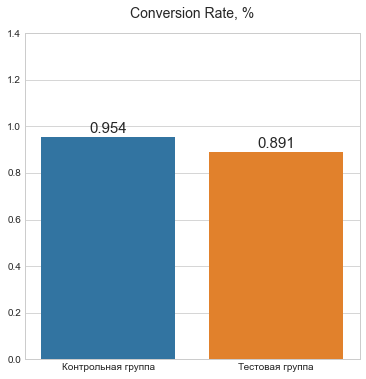

In [13]:
plt.figure(figsize=(6,6)) 

plots =sns.barplot(x=['Контрольная группа','Тестовая группа'], y=report_converion['conversion_rate, %']) 
 
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.ylim(0, 1.4) 
plt.title( 'Conversion Rate, %', pad=15, size=14) 
#plt.xlabel('Группа', fontsize=14) 
plt.ylabel('');

Как видно из графика коверсия Контрольной группы больше тестовой. Проверим является ли эта разница статистически значимой ?

In [14]:
print(f"""Нулевая гипотеза - различий между конверсиями тестовой и контрольной групп нет
Альтернативная гипотеза - коверсии тестовой и контрольной групп различаются
Hₒ: CR = CRₒ
Hₐ: CR ≠ CRₒ
Мы также установим уровень достоверности 95%:
α = 0,05""")

Нулевая гипотеза - различий между конверсиями тестовой и контрольной групп нет
Альтернативная гипотеза - коверсии тестовой и контрольной групп различаются
Hₒ: CR = CRₒ
Hₐ: CR ≠ CRₒ
Мы также установим уровень достоверности 95%:
α = 0,05


In [15]:
print(f"Так как наша выборка большая - {df.shape[0]}, мы можем использовать нормальное приближение для расчета p-value (т. е. z-критерий).")

Так как наша выборка большая - 404770, мы можем использовать нормальное приближение для расчета p-value (т. е. z-критерий).


In [16]:
alpha = 0.05
nobs      = [report_converion.loc['a','total_users'], report_converion.loc['b','total_users']]
successes = [report_converion.loc['a','converted_users'], report_converion.loc['b','converted_users']]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z-statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

if pval < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

z-statistic: 2.11
p-value: 0.035
ci 95% for control group: [0.009, 0.010]
ci 95% for treatment group: [0.008, 0.009]
Отвергаем нулевую гипотезу


In [17]:
print(f"Так как {pval:.3f} < {alpha}, отвергаем нулевую гипотезу о равенстве конверсий в двух группах.\nСледовательно, конверсия в контрольной группе больше коверсии в тестовой, и разница является статистически значимой\nна уровне доверия 95%.\nИз этого можно сделать вывод, что вариант акции а лучше, чем b. ")

Так как 0.035 < 0.05, отвергаем нулевую гипотезу о равенстве конверсий в двух группах.
Следовательно, конверсия в контрольной группе больше коверсии в тестовой, и разница является статистически значимой
на уровне доверия 95%.
Из этого можно сделать вывод, что вариант акции а лучше, чем b. 


#### ARPU 

Посмотрим на показатель ARPU (Average Revenue Per User) показывает, сколько денег в среднем приносит компании один пользователь за определенный промежуток времени.

`Average Revenue Per User = весь доход за период / количество пользователей за период`

In [18]:
df.head()

,user_id,revenue,testgroup,converted
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


In [19]:
report_ARPU = df.groupby('testgroup').agg({'revenue':'sum', 'user_id':'nunique'})
report_ARPU.columns = ['total_revenue', 'total_users']
report_ARPU['ARPU'] = report_ARPU['total_revenue'] / report_ARPU['total_users']

In [20]:
report_ARPU

,total_revenue,total_users,ARPU
testgroup,,,
a,5136189,202103,25.413720
b,5421603,202667,26.751287


In [21]:
print(f"ARPU в тестовой группе составляет    {report_ARPU.loc['b','ARPU']:.2f}")
print(f"ARPU в контрольной группе составляет {report_ARPU.loc['a','ARPU']:.2f}")
print(f"ARPU в тестовой группе больше на {((report_ARPU.loc['b','ARPU']-report_ARPU.loc['a','ARPU'])*100 / report_ARPU.loc['b','ARPU']):.1f}%, чем в контрольной")

ARPU в тестовой группе составляет    26.75
ARPU в контрольной группе составляет 25.41
ARPU в тестовой группе больше на 5.0%, чем в контрольной


Проверим является ли данная разница статистически значимой с помощью метода бутстрап. Для этого напишем функцию get_bootstrap на вход, которой подаются значения тестовой и контрольной групп, количество бутстреп выборок, статистика и уровень значимости

In [22]:
group_a = df.query("testgroup == 'a'").revenue
group_b = df.query("testgroup == 'b'").revenue

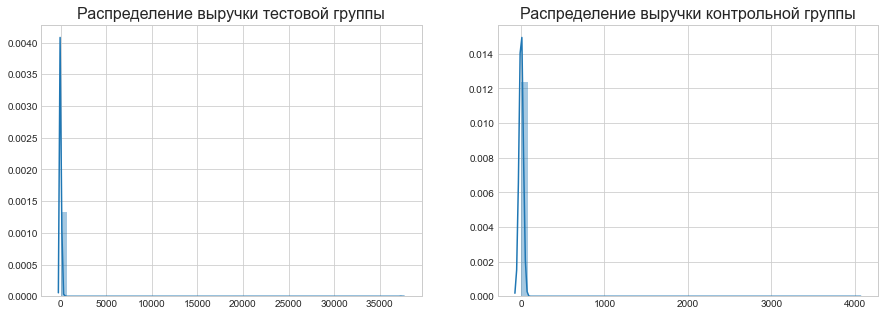

In [23]:
plt.figure(figsize=(15, 5))


plt.subplot(1,2,1)
sns.distplot(group_a)
plt.title('Распределение выручки тестовой группы',fontsize=16)
plt.xlabel('')
plt.ylabel('')

plt.subplot(1,2,2)
sns.distplot(group_b)
plt.title('Распределение выручки контрольной группы',fontsize=16)
plt.xlabel('')
plt.ylabel('');

Из графиков видно, что распределения выборок смещено влево и сосредоточено около нуля, также они имеют большой разброс, совсем не похожи на нормальное распреление.Поэтому проверим является ли данная разница статистически значимой с помощью метода бутстрап. 
Для этого напишем функцию get_bootstrap на вход, которой подаются значения тестовой и контрольной групп, количество бутстреп выборок, статистика и уровень значимости

In [24]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа 
def get_bootstrap(
    data_column_1,                 # числовые значения первой подвыборки
    data_column_2,                 # числовые значения второй подвыборки
    boot_it = 1000,                # количество бутстреп-подвыборок
    statistic = np.mean,           # интересующая нас статистика
    bootstrap_conf_level = 0.95    # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it):
        samples_1 = data_column_1.sample(
            boot_len,
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    left_quant = (1-bootstrap_conf_level)/2
    right_quant = 1-(1-bootstrap_conf_level)/2
    ci = pd_boot_data.quantile([left_quant,right_quant])
        
    # считаем  p_value по нормальному распределению
    p_1 = norm.cdf(
        x=0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1,p_2) * 2
        
    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

In [25]:
result = get_bootstrap(group_a,group_b)

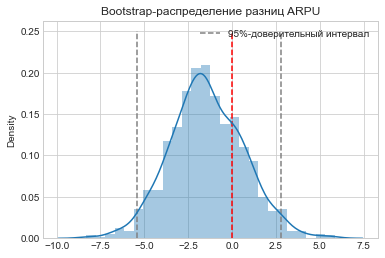

Статистически значимой разницы в ARPU не обнаружено, так как 0 входит в доверительный интервал разницы между группами.
Следовательно, нет оснований говорить, что ARPU тестовой группы больше контрольной и акция а лучше акции b.


In [26]:
sns.distplot(result['boot_data']) # функция построения распределения
plt.title('Bootstrap-распределение разниц ARPU')
plt.rcParams["figure.figsize"] = (12, 6)
plt.vlines(0, # отрисуем линию на уровне ноля
           ymin = 0, 
           ymax = 0.25, 
           linestyles= '--', 
           colors = 'red')
plt.vlines(result['ci'], # отрисуем перцентили
           ymin = 0, 
           ymax = 0.25, 
           linestyles= '--', 
           colors = 'grey', 
           label = '95%-доверительный интервал')
plt.legend()
plt.show()
print("Статистически значимой разницы в ARPU не обнаружено, так как 0 входит в доверительный интервал разницы между группами.")
print("Следовательно, нет оснований говорить, что ARPU тестовой группы больше контрольной и акция а лучше акции b.");

#### ARPPU

Также рассмотрим метрику ARPPU (Average Revenue Per Paying User), учитывающую только платяжих клиентов

`Общий доход за период / Количество платящих пользователей за период`

In [27]:
report_ARPPU = df[df['revenue'] > 0].groupby('testgroup').agg({'revenue':'sum', 'user_id':'nunique'})
report_ARPPU.columns = ['total_revenue', 'total_paying_users']
report_ARPPU['ARPPU'] = report_ARPPU['total_revenue'] / report_ARPPU['total_paying_users']

In [28]:
report_ARPPU

,total_revenue,total_paying_users,ARPPU
testgroup,,,
a,5136189,1928,2663.998444
b,5421603,1805,3003.658172


In [29]:
print(f"ARPPU в тестовой группе составляет    {report_ARPPU.loc['b','ARPPU']:.2f}")
print(f"ARPPU в контрольной группе составляет {report_ARPPU.loc['a','ARPPU']:.2f}")
print(f"ARPPU в тестовой группе больше на {((report_ARPPU.loc['b','ARPPU']-report_ARPPU.loc['a','ARPPU'])*100 / report_ARPPU.loc['b','ARPPU']):.1f}%, чем в контрольной")

ARPPU в тестовой группе составляет    3003.66
ARPPU в контрольной группе составляет 2664.00
ARPPU в тестовой группе больше на 11.3%, чем в контрольной


In [30]:
group_a_more_0 = df[(df['revenue'] > 0) & (df['testgroup'] == 'a')].revenue
group_b_more_0 = df[(df['revenue'] > 0) & (df['testgroup'] == 'b')].revenue

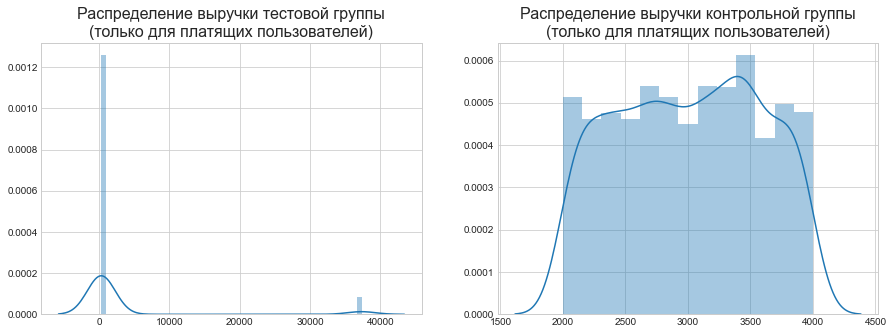

In [31]:
plt.figure(figsize=(15, 5))


plt.subplot(1,2,1)
sns.distplot(group_a_more_0)
plt.title('Распределение выручки тестовой группы\n(только для платящих пользователей)',fontsize=16)
plt.xlabel('')
plt.ylabel('')

plt.subplot(1,2,2)
sns.distplot(group_b_more_0)
plt.title('Распределение выручки контрольной группы\n(только для платящих пользователей)',fontsize=16)
plt.xlabel('')
plt.ylabel('');

Исходя из графиков распределения далеки от нормального, поэтому для проверки статистической значимости ARPPU будем снова использовать бутстрап метод с помощью функции get_bootstrap

In [32]:
res_more_0 = get_bootstrap(group_a_more_0, group_b_more_0)

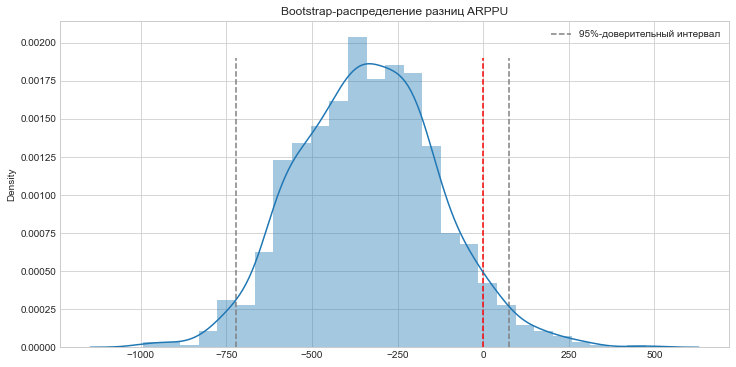

Статистически значимой разницы в ARPPU не обнаружено, так как 0 входит в доверительный интервал разницы между группами.
Следовательно, нет оснований говорить, что ARPPU тестовой группы больше контрольной и акция A лучше акции B.


In [33]:
sns.distplot(res_more_0['boot_data']) # функция построения распределения
plt.title('Bootstrap-распределение разниц ARPPU')
plt.rcParams["figure.figsize"] = (12, 6)
plt.vlines(0, # отрисуем линию на уровне ноля
           ymin = 0, 
           ymax = 0.0019, 
           linestyles= '--', 
           colors = 'red')
plt.vlines(res_more_0['ci'], # отрисуем перцентили
           ymin = 0, 
           ymax = 0.0019, 
           linestyles= '--', 
           colors = 'grey', 
           label = '95%-доверительный интервал')
plt.legend()
plt.show()
print("Статистически значимой разницы в ARPPU не обнаружено, так как 0 входит в доверительный интервал разницы между группами.")
print("Следовательно, нет оснований говорить, что ARPPU тестовой группы больше контрольной и акция A лучше акции B.");

## ВЫВОД

In [34]:
report = report_ARPU.merge(report_ARPPU).merge(report_converion)
report = report[['ARPU','ARPPU','conversion_rate, %']].round(2)
report.index = ['Контрольная группа','Тестовая группа']
print(report)
print('_________________________________________________________\n')
print(f"ARPPU в тестовой группе больше на {((report_ARPPU.loc['b','ARPPU']-report_ARPPU.loc['a','ARPPU'])*100 / report_ARPPU.loc['b','ARPPU']):.1f}%, чем в контрольной, данная разница статистически не значима")
print(f"ARPU в тестовой группе больше на {((report_ARPU.loc['b','ARPU']-report_ARPU.loc['a','ARPU'])*100 / report_ARPU.loc['b','ARPU']):.1f}%, чем в контрольной, данная разница статистически не значима")
print(f"Conversion Rate в тестовой группе меньше на {((report.loc['Контрольная группа','conversion_rate, %']- report.loc['Тестовая группа','conversion_rate, %'])*100 / report.loc['Контрольная группа','conversion_rate, %']):.1f}%, чем в контрольной, данная разница статистически значима на уровне доверия 95%")

                     ARPU    ARPPU  conversion_rate, %
Контрольная группа  25.41  2664.00                0.95
Тестовая группа     26.75  3003.66                0.89
_________________________________________________________

ARPPU в тестовой группе больше на 11.3%, чем в контрольной, данная разница статистически не значима
ARPU в тестовой группе больше на 5.0%, чем в контрольной, данная разница статистически не значима
Conversion Rate в тестовой группе меньше на 6.3%, чем в контрольной, данная разница статистически значима на уровне доверия 95%


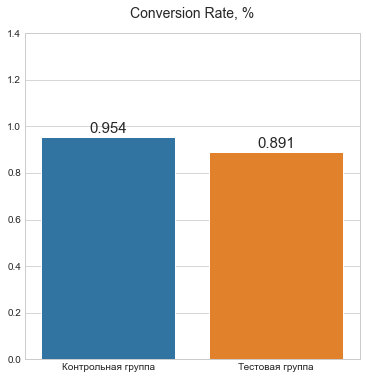

Лучше оставить вариант акции А, предлагаемый контрольной группе, так как вариант В не увеличил ARPU и ARPPU и уменьшил конверсию в покупку

# Задание 3

*В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?*

`Метрики, которые необходимо отслеживать:`
 - DAU
 - Sticky Factor
 - Retention 
 - Total Daily Play Time


1. **DAU** (Daily Active Users - число пользоватей, которые заходили в игру в определенный день)будем отслеживать для того, что бы отслеживать нравится ли пользователям наше текущее тематическое событие. DAU не должен падать

2. Стоит также измерить **Sticky Factor** (коэффициент «липучести» = среднее DAU/MAU)за текущий месяц проведения тематического события и сравнить с данными по этой метрике за предыдущие периоды. Ожидаем, что Sticky Factor увеличится, то есть это будет означать, что пользователям понравилось данное событие и они регулярно заходили в течение месяца проведения события.

3. Стоит отслеживать **Retention Rate** (коэффициент удержания пользователей) по когортам, ожидаем, что Retention Rate будет не падать, то есть пользователи регулярно будут возвращаться в игру.

4. **Total Daily Play Time** также будем ожидать, что увеличится, то есть пользователи будут дольше находится в игре, что означает, что им нравится данное событие.

*Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?*

Можно оставить выше уже перечисленные метрики, добавив разделение на пользователей, которые откатились на несколько уровней назад N раз. Интересно посмотреть на их поведение с течением времени, если их метрики будут меньше/падать с течением времени в отличие от пользователей, которые проходят уровни без неудачных попыток, то это будет означать, что пользователям не нравится, что их откидывает назад и им по много раз приходится проходить одни и те же уровни, и есть риск их потерять.